#Loading the Dataset

In [36]:
#import all of the needed libraries
import os
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image
from keras.applications import resnet
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Flatten, Dense
from keras.models import Sequential, Model, load_model
from keras import metrics
from keras.applications import resnet, resnet_v2, densenet, mobilenet, mobilenet_v2
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate, ZeroPadding2D, ReLU, DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.constraints import max_norm, min_max_norm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#get the train directory
train_directory = '/content/drive/MyDrive/train'
test_directory = '/content/drive/MyDrive/test'

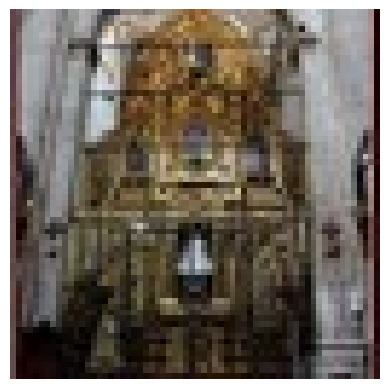

In [71]:
from PIL import Image
plt.imshow(Image.open("/content/drive/MyDrive/train/altar/10039.jpg"))
plt.axis('off')
plt.show()

In [39]:
#first we define a list of all of the classes
classes = ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle',
              'stained_glass', 'vault']

In [40]:
#here we count the number of samples(images) of each class in our training data
for class_ in classes:
    print('The number of images in ' + str(class_) + ' is' ,len(os.listdir(os.path.join(train_directory, class_))))

The number of images in altar is 828
The number of images in apse is 505
The number of images in bell_tower is 1057
The number of images in column is 1914
The number of images in dome(inner) is 589
The number of images in dome(outer) is 1175
The number of images in flying_buttress is 405
The number of images in gargoyle is 1562
The number of images in stained_glass is 1008
The number of images in vault is 1097


In [41]:
#here we count the number of samples(images) of each class
for class_ in classes:
    print('The number of images in ' + str(class_) + ' is' ,len(os.listdir(os.path.join(test_directory, class_))))

The number of images in altar is 140
The number of images in apse is 50
The number of images in bell_tower is 170
The number of images in column is 210
The number of images in dome(inner) is 69
The number of images in dome(outer) is 142
The number of images in flying_buttress is 70
The number of images in gargoyle is 240
The number of images in stained_glass is 150
The number of images in vault is 163


#Converting info into a dataframe

In [42]:
#in this section we're trying to create a data frame made of images' path and the id and name of the class the belong to
data = []
for class_id , class_ in enumerate(classes):
    for path in os.listdir(os.path.join(train_directory, class_)):
        data.append([os.path.join(train_directory, class_, path), class_id, class_])
#use the list to create a data frame
IMAGES = pd.DataFrame(data, columns=['Image_Path', 'ClassID', 'Class'])

In [43]:
IMAGES.tail(8)

,Image_Path,ClassID,Class
10132,/content/drive/MyDrive/train/vault/8856.jpg,9,vault
10133,/content/drive/MyDrive/train/vault/8656.jpg,9,vault
10134,/content/drive/MyDrive/train/vault/8603.jpg,9,vault
10135,/content/drive/MyDrive/train/vault/9094.jpg,9,vault
10136,/content/drive/MyDrive/train/vault/8611.jpg,9,vault
10137,/content/drive/MyDrive/train/vault/8518.jpg,9,vault
10138,/content/drive/MyDrive/train/vault/8793.jpg,9,vault
10139,/content/drive/MyDrive/train/vault/8660.jpg,9,vault


In [44]:
IMAGES.shape

(10140, 3)

In [45]:
filtered_images = IMAGES.loc[IMAGES['Class'] == 'bell_tower']
filtered_images

,Image_Path,ClassID,Class
1333,/content/drive/MyDrive/train/bell_tower/81.jpg,2,bell_tower
1334,/content/drive/MyDrive/train/bell_tower/588.jpg,2,bell_tower
1335,/content/drive/MyDrive/train/bell_tower/695.jpg,2,bell_tower
1336,/content/drive/MyDrive/train/bell_tower/694.jpg,2,bell_tower
1337,/content/drive/MyDrive/train/bell_tower/207.jpg,2,bell_tower
...,...,...,...
2385,/content/drive/MyDrive/train/bell_tower/303.jpg,2,bell_tower
2386,/content/drive/MyDrive/train/bell_tower/57.jpg,2,bell_tower
2387,/content/drive/MyDrive/train/bell_tower/86.jpg,2,bell_tower
2388,/content/drive/MyDrive/train/bell_tower/110.jpg,2,bell_tower


In [46]:
data_test = []
for class_id , class_ in enumerate(classes):
    for path in os.listdir(os.path.join(test_directory, class_)):
        data_test.append([os.path.join(test_directory, class_, path), class_id, class_])
#use the list to create a data frame
IMAGES_TEST = pd.DataFrame(data_test, columns=['Image_Path_test', 'ClassID_test', 'Class_test'])

In [47]:
IMAGES_TEST.head(5)

,Image_Path_test,ClassID_test,Class_test
0,/content/drive/MyDrive/test/altar/251.jpg,0,altar
1,/content/drive/MyDrive/test/altar/309.jpg,0,altar
2,/content/drive/MyDrive/test/altar/344.jpg,0,altar
3,/content/drive/MyDrive/test/altar/317.jpg,0,altar
4,/content/drive/MyDrive/test/altar/247.jpg,0,altar


In [48]:
IMAGES_TEST.shape

(1404, 3)

#Resizing images

In [50]:
#first we do it for all of the images in our training set
Feature_train = []
Target_train = IMAGES['ClassID']
for path in IMAGES['Image_Path'].values.tolist():
  img = image.load_img(path, target_size=(16,16))
  img = image.img_to_array(img)
  Feature_train.append(img)

In [51]:
#covert our features(images) and taregt into numpy array
X = np.array(Feature_train)
y = np.array(Target_train)

In [53]:
#now we do it for our testing set
Feature_test = []
Target_test = IMAGES_TEST['ClassID_test']
for path in IMAGES_TEST['Image_Path_test'].values.tolist():
  img = image.load_img(path,target_size=(16,16))
  img = image.img_to_array(img)
  Feature_test.append(img)

In [54]:
#covert our features(images) and taregt into numpy array
X_test = np.array(Feature_test)
y_test = np.array(Target_test)

#Model

In [55]:
#define a function for splitting our data
seed = 1
def divide_fold(k, X, y):
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(X, y))
    return folds

In [57]:
#here we define our model which a sequential model with cnn layers and maxpooling and drop out being applies after some of the layers
def classifier():

    x = Input((16, 16, 3))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.2)(model)


    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)


    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)


    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)


    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.2)(model)


    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.2)(model)


    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'same',
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = GlobalAveragePooling2D()(model)


    model = Dense(64, activation = 'elu')(model)
    model = Dense(len(classes), activation = 'softmax')(model)
    model = Model(inputs=x, outputs=model)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                  metrics=['accuracy'])

    return model

In [58]:
model = classifier()

In [59]:
#imagedatagenerator will help us to modify images like zooming in or zooming out
data_generator = image.ImageDataGenerator(horizontal_flip=True, brightness_range = [0.5,2], zoom_range=0.2)

In [60]:
folds = divide_fold(5, X, y)

In [67]:
for j, (train_data, val_data) in enumerate(folds):

    print('\nThis is the '+str(j)+'th Fold')
    X_train = X[train_data]
    y_train  = y[train_data]
    X_valid = X[val_data]
    y_valid = y[val_data]
    callbacks = reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')
    X_train = np.expand_dims(X_train, axis=0)
    X_train = X_train[0]
    #set the batch size 64
    generator = data_generator.flow(X_train, y_train, batch_size=64)
    #here we fit our model to our data
    model_history = model.fit(
                generator,
                steps_per_epoch=len(X_train)/64,
                epochs=6,
                shuffle=True,
                verbose=1,
                validation_data=(X_valid, y_valid),
                callbacks=callbacks)
    print(model.evaluate(X_valid, y_valid))


This is the 0th Fold
Epoch 1/6
126/126 [==============================] - 19s 146ms/step - loss: 0.7402 - accuracy: 0.7477 - val_loss: 0.7183 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 2/6
126/126 [==============================] - 18s 142ms/step - loss: 0.7430 - accuracy: 0.7453 - val_loss: 0.6964 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 3/6
126/126 [==============================] - 18s 142ms/step - loss: 0.7158 - accuracy: 0.7575 - val_loss: 0.6933 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 4/6
126/126 [==============================] - 20s 159ms/step - loss: 0.7133 - accuracy: 0.7581 - val_loss: 0.6506 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 5/6
126/126 [==============================] - 20s 161ms/step - loss: 0.6833 - accuracy: 0.7615 - val_loss: 0.6348 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 6/6
64/64 [==============================] - 1s 13ms/step - loss: 0.8611 - accuracy: 0.7219


[0.8611292243003845, 0.7218934893608093]

This is the 1th Fold
Epoch 1/6
126/126 [==============================] - 18s 142ms/step - loss: 0.7050 - accuracy: 0.7596 - val_loss: 0.5057 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 2/6
126/126 [==============================] - 20s 154ms/step - loss: 0.6995 - accuracy: 0.7574 - val_loss: 0.5185 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 3/6
126/126 [==============================] - 21s 169ms/step - loss: 0.6820 - accuracy: 0.7679 - val_loss: 0.4843 - val_accuracy: 0.8304 - lr: 0.0010
Epoch 4/6
126/126 [==============================] - 17s 137ms/step - loss: 0.6790 - accuracy: 0.7674 - val_loss: 0.5706 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 5/6
126/126 [==============================] - 20s 154ms/step - loss: 0.6623 - accuracy: 0.7681 - val_loss: 0.5703 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 6/6
64/64 [==============================] - 1s 13ms/step - loss: 0.4768 - accuracy: 0.8358


[0.47681924700737, 0.8357987999916077]

This is the 2th Fold
Epoch 1/6
126/126 [==============================] - 18s 138ms/step - loss: 0.6658 - accuracy: 0.7718 - val_loss: 0.4485 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 2/6
126/126 [==============================] - 20s 155ms/step - loss: 0.6415 - accuracy: 0.7800 - val_loss: 0.4207 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 3/6
126/126 [==============================] - 18s 141ms/step - loss: 0.6246 - accuracy: 0.7803 - val_loss: 0.4837 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 4/6
126/126 [==============================] - 19s 151ms/step - loss: 0.6194 - accuracy: 0.7872 - val_loss: 0.4264 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 5/6
126/126 [==============================] - 18s 140ms/step - loss: 0.6277 - accuracy: 0.7819 - val_loss: 0.5807 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 6/6
64/64 [==============================] - 1s 14ms/step - loss: 0.4482 - accuracy: 0.8383


[0.44823530316352844, 0.8382642865180969]

This is the 3th Fold
Epoch 1/6
126/126 [==============================] - 18s 142ms/step - loss: 0.6145 - accuracy: 0.7878 - val_loss: 0.4306 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 2/6
126/126 [==============================] - 18s 138ms/step - loss: 0.6286 - accuracy: 0.7809 - val_loss: 0.4703 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 3/6
126/126 [==============================] - 20s 158ms/step - loss: 0.5977 - accuracy: 0.7946 - val_loss: 0.4586 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 4/6
126/126 [==============================] - 19s 148ms/step - loss: 0.5920 - accuracy: 0.7982 - val_loss: 0.4325 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 5/6
126/126 [==============================] - 18s 138ms/step - loss: 0.5800 - accuracy: 0.7971 - val_loss: 0.4879 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 6/6
64/64 [==============================] - 1s 15ms/step - loss: 0.4352 - accuracy: 0.8536


[0.4352121949195862, 0.8535503149032593]

This is the 4th Fold
Epoch 1/6
126/126 [==============================] - 17s 137ms/step - loss: 0.5993 - accuracy: 0.7887 - val_loss: 0.3514 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 2/6
126/126 [==============================] - 19s 151ms/step - loss: 0.5777 - accuracy: 0.8042 - val_loss: 0.3846 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 3/6
126/126 [==============================] - 18s 140ms/step - loss: 0.5803 - accuracy: 0.7986 - val_loss: 0.3621 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 4/6
126/126 [==============================] - 18s 138ms/step - loss: 0.5585 - accuracy: 0.8110 - val_loss: 0.4791 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 5/6
126/126 [==============================] - 18s 141ms/step - loss: 0.5602 - accuracy: 0.8081 - val_loss: 0.4110 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 6/6
64/64 [==============================] - 1s 15ms/step - loss: 0.4736 - accuracy: 0.8491
[0.47355425357818604, 0.8491124510765076]


#Evaluation

In [69]:
#Print the evaluation results
evaluation_results = model.evaluate(x=X_test, y=y_test, batch_size=64)
print(f"Validation Loss: {evaluation_results[0]}")
print(f"Validation Accuracy: {evaluation_results[1]}")

22/22 [==============================] - 1s 53ms/step - loss: 0.8670 - accuracy: 0.7151
Validation Loss: 0.8669895529747009
Validation Accuracy: 0.7150996923446655
